In [1]:
!pip install gymnasium[atari] ale-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.3.0
    Uninstalling Shimmy-1.3.0:
      Successfully uninstalled Shimmy-1.3.0
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.10.2
    Uninstalling ale-py-0.10.2:
      Successfully uninstalled ale-py-0.10.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.11 requires shimmy>=1.2.1, but you have shimmy 0.2.1 which is incompatible.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, but you have ale-py 0.8.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.


In [2]:
import ale_py
!pip install autorom[accept-rom-license]
!AutoROM --accept-license

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.1 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446709 sha256=700ecdce94d747e9759397d9df359aa4dd9d840139318c283fada52bba9c32a6
  Stored in directory: /root/.cache/pip/wheels/bc/fc/c6/8aa657c0d2089982f2dabd110efc68c61eb49831fdb7397351
Successfully built AutoROM.accept-rom-license
AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.11/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


In [11]:
import gymnasium as gym

envs = gym.envs.registry.keys()
for env_id in sorted(envs):
    print(env_id)

ALE/Adventure-ram-v5
ALE/Adventure-v5
ALE/AirRaid-ram-v5
ALE/AirRaid-v5
ALE/Alien-ram-v5
ALE/Alien-v5
ALE/Amidar-ram-v5
ALE/Amidar-v5
ALE/Assault-ram-v5
ALE/Assault-v5
ALE/Asterix-ram-v5
ALE/Asterix-v5
ALE/Asteroids-ram-v5
ALE/Asteroids-v5
ALE/Atlantis-ram-v5
ALE/Atlantis-v5
ALE/Atlantis2-ram-v5
ALE/Atlantis2-v5
ALE/Backgammon-ram-v5
ALE/Backgammon-v5
ALE/BankHeist-ram-v5
ALE/BankHeist-v5
ALE/BasicMath-ram-v5
ALE/BasicMath-v5
ALE/BattleZone-ram-v5
ALE/BattleZone-v5
ALE/BeamRider-ram-v5
ALE/BeamRider-v5
ALE/Berzerk-ram-v5
ALE/Berzerk-v5
ALE/Blackjack-ram-v5
ALE/Blackjack-v5
ALE/Bowling-ram-v5
ALE/Bowling-v5
ALE/Boxing-ram-v5
ALE/Boxing-v5
ALE/Breakout-ram-v5
ALE/Breakout-v5
ALE/Carnival-ram-v5
ALE/Carnival-v5
ALE/Casino-ram-v5
ALE/Casino-v5
ALE/Centipede-ram-v5
ALE/Centipede-v5
ALE/ChopperCommand-ram-v5
ALE/ChopperCommand-v5
ALE/CrazyClimber-ram-v5
ALE/CrazyClimber-v5
ALE/Crossbow-ram-v5
ALE/Crossbow-v5
ALE/Darkchambers-ram-v5
ALE/Darkchambers-v5
ALE/Defender-ram-v5
ALE/Defender-v5
ALE/

In [12]:
import cv2
import numpy as np
from collections import deque
import gymnasium as gym

def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
    return frame / 255.0  # Normalize to [0, 1]

In [13]:
class FrameStack(gym.Wrapper):
    def __init__(self, env, k=4):
        super().__init__(env)
        self.k = k
        self.frames = deque([], maxlen=k)
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(k, 84, 84), dtype=np.float32)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        processed = preprocess_frame(obs)
        for _ in range(self.k):
            self.frames.append(processed)
        return np.array(self.frames, dtype=np.float32), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        processed = preprocess_frame(obs)
        self.frames.append(processed)
        done = terminated or truncated
        return np.array(self.frames, dtype=np.float32), reward, done, info

In [14]:
class FrameSkip(gym.Wrapper):
    def __init__(self, env, skip=4):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        terminated = False
        truncated = False
        info = {}

        for _ in range(self._skip):
            obs, reward, term, trunc, info = self.env.step(action)
            total_reward += reward
            if term or trunc:
                terminated = term
                truncated = trunc
                break

        return obs, total_reward, terminated, truncated, info

In [15]:
env = FrameStack(
    FrameSkip(
        gym.make("ALE/Pong-v5", render_mode="rgb_array"),
        skip=4
    ),
    k=4
)

obs, info = env.reset()
print("State shape:", obs.shape)  # (4, 84, 84)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


State shape: (4, 84, 84)


In [16]:
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        # Store raw pixels as uint8 to save RAM
        self.buffer.append((
            (state * 255).astype(np.uint8),
            action,
            reward,
            (next_state * 255).astype(np.uint8),
            done
        ))

    def sample(self, batch_size):
      batch = random.sample(self.buffer, batch_size)
      states, actions, rewards, next_states, dones = zip(*batch)

      # Convert back to float32 and normalize to [0, 1]
      return (
          np.array(states, dtype=np.uint8).astype(np.float32) / 255.0,
          np.array(actions, dtype=np.int64),
          np.array(rewards, dtype=np.float32),
          np.array(next_states, dtype=np.uint8).astype(np.float32) / 255.0,
          np.array(dones, dtype=np.float32),
      )

    def __len__(self):
        return len(self.buffer)

In [17]:
import torch
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        c, h, w = input_shape

        self.net = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512), nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        return self.net(x)

In [18]:
import torch

INPUT_SHAPE = (4, 84, 84)
NUM_ACTIONS = env.action_space.n

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy_net = DQN(INPUT_SHAPE, NUM_ACTIONS).to(device)
target_net = DQN(INPUT_SHAPE, NUM_ACTIONS).to(device)
target_net.load_state_dict(policy_net.state_dict())  # Initialize target net
target_net.eval()

DQN(
  (net): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [19]:
def select_action(model, state, epsilon, num_actions):
    if random.random() < epsilon:
        return random.randrange(num_actions)
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        q_values = model(state_tensor)
    return q_values.argmax(dim=1).item()

In [20]:
# Hyperparameters
GAMMA = 0.99
LR = 1e-4
BATCH_SIZE = 32
BUFFER_SIZE = 100_000
MIN_REPLAY_SIZE = 50_000
TARGET_UPDATE_FREQ = 10000
EPS_START = 1.0
EPS_END = 0.0
EPS_DECAY = 1_000_000
TOTAL_FRAMES = 8_000_000

# Initialize optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=LR)

In [22]:
def compute_td_loss(batch, policy_net, target_net):
    states, actions, rewards, next_states, dones = batch

    states = torch.tensor(states, dtype=torch.float32, device=device)
    actions = torch.tensor(actions, dtype=torch.int64, device=device)
    rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
    next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
    dones = torch.tensor(dones, dtype=torch.float32, device=device)

    q_values = policy_net(states)
    next_q_values = target_net(next_states)

    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    max_next_q_value = next_q_values.max(1)[0]
    expected_q_value = rewards + GAMMA * max_next_q_value * (1 - dones)

    loss = nn.MSELoss()(q_value, expected_q_value.detach())
    return loss

In [23]:
import matplotlib.pyplot as plt

def plot_rewards(rewards, window=10):
    if len(rewards) < window:
        print("Not enough episodes to plot yet.")
        return
    moving_avg = [np.mean(rewards[max(0, i - window):i + 1]) for i in range(len(rewards))]

    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Episode reward")
    plt.plot(moving_avg, label=f"{window}-episode moving average")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("DQN Training Progress on Pong")
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
CHECKPOINT_PATH = "/kaggle/working/TFG-RL/"

In [25]:
import os
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [26]:
import numpy as np

def save_full_checkpoint(frame_idx, policy_net, target_net, optimizer, replay_buffer, episode_rewards, filename_prefix="dqn_full_checkpoint"):
    # Save everything *except* the buffer using torch
    model_checkpoint = {
        'frame_idx': frame_idx,
        'model_state_dict': policy_net.state_dict(),
        'target_state_dict': target_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'episode_rewards': episode_rewards
    }

    torch.save(model_checkpoint, filename_prefix + ".pth")

    # Save the replay buffer separately with NumPy
    np.savez_compressed(filename_prefix + "_buffer.npz", buffer=np.array(list(replay_buffer.buffer), dtype=object))  # convert deque to list

    print(f"Checkpoint saved at frame {frame_idx} → {filename_prefix}.pth + _buffer.npz")

In [28]:
def load_full_checkpoint(filename_prefix, policy_net, target_net, optimizer, buffer_capacity=BUFFER_SIZE):
    # Load model/optimizer/metadata
    checkpoint = torch.load(filename_prefix + ".pth", weights_only=False)

    policy_net.load_state_dict(checkpoint['model_state_dict'])
    target_net.load_state_dict(checkpoint['target_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    try:
        # Load replay buffer separately
        buffer_data = np.load(filename_prefix + "_buffer.npz", allow_pickle=True)['buffer']
        replay_buffer = ReplayBuffer(capacity=buffer_capacity)
        replay_buffer.buffer = deque(buffer_data.tolist(), maxlen=buffer_capacity)
        print(len(replay_buffer))
    except:
        raise FileNotFoundError("Replay buffer file is missing or empty.")

    print(f"Loaded model and optimizer from checkpoint at frame {checkpoint['frame_idx']}")

    return (
        checkpoint['frame_idx'],
        replay_buffer,
        checkpoint['episode_rewards']
    )

In [29]:
def save_best_model(frame_idx, policy_net, target_net, optimizer, episode_rewards, filename_prefix="best_dqn_model"):
    checkpoint = {
        'frame_idx': frame_idx,
        'model_state_dict': policy_net.state_dict(),
        'target_state_dict': target_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'episode_rewards': episode_rewards
    }
    torch.save(checkpoint, filename_prefix + ".pth")
    print(f"Best model saved at frame {frame_idx} → {filename_prefix}.pth")

In [30]:
def load_best_model(filename_prefix, policy_net, target_net, optimizer):
    checkpoint = torch.load(filename_prefix + ".pth", weights_only=False)

    policy_net.load_state_dict(checkpoint['model_state_dict'])
    target_net.load_state_dict(checkpoint['target_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"Loaded best model from frame {checkpoint['frame_idx']}")

    return (checkpoint['frame_idx'], checkpoint['episode_rewards'])

In [31]:
LOAD_FILE = "dqn_full_checkpoint"

In [33]:
try:
    frame_idx, replay_buffer, episode_rewards = load_full_checkpoint(
        CHECKPOINT_PATH + LOAD_FILE, policy_net, target_net, optimizer
    )
except FileNotFoundError or EOFError:
    frame_idx = 0
    replay_buffer = ReplayBuffer(BUFFER_SIZE)
    episode_rewards = []
    print("Starting from scratch")

100000
Loaded model and optimizer from checkpoint at frame 7999999


In [ ]:
avg_reward = np.mean(episode_rewards[-10:]) if episode_rewards else 0
avg_reward

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

def plot_rewards(rewards, window=10):
    if len(rewards) < window:
        print("Not enough episodes to plot yet.")
        return
    moving_avg = [np.mean(rewards[max(0, i - window):i + 1]) for i in range(len(rewards))]

    plt.figure(figsize=(10, 8))
    plt.rcParams.update({'font.size': 24})

    # Plot lines normally
    line1, = plt.plot(rewards, alpha=0.5, color="#1f78b4")
    line2, = plt.plot(moving_avg, color="#ff6d29")

    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("DQN Training Progress on Pong")
    plt.grid(True)

    # Custom square-shaped legend handles
    custom_legend = [
        Line2D([0], [0], marker='s', color='w', label='Episode reward',
               markerfacecolor="#1f78b4", markersize=14),
        Line2D([0], [0], marker='s', color='w', label=f"{window}-episode moving average",
               markerfacecolor="#ff6d29", markersize=14)
    ]

    plt.legend(
        handles=custom_legend,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.2),
        ncol=2,
        frameon=True,            # <<< This adds the box
        framealpha=1.0,          # Solid background
        edgecolor='black',       # Box border color
        fancybox=True 
    )

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()


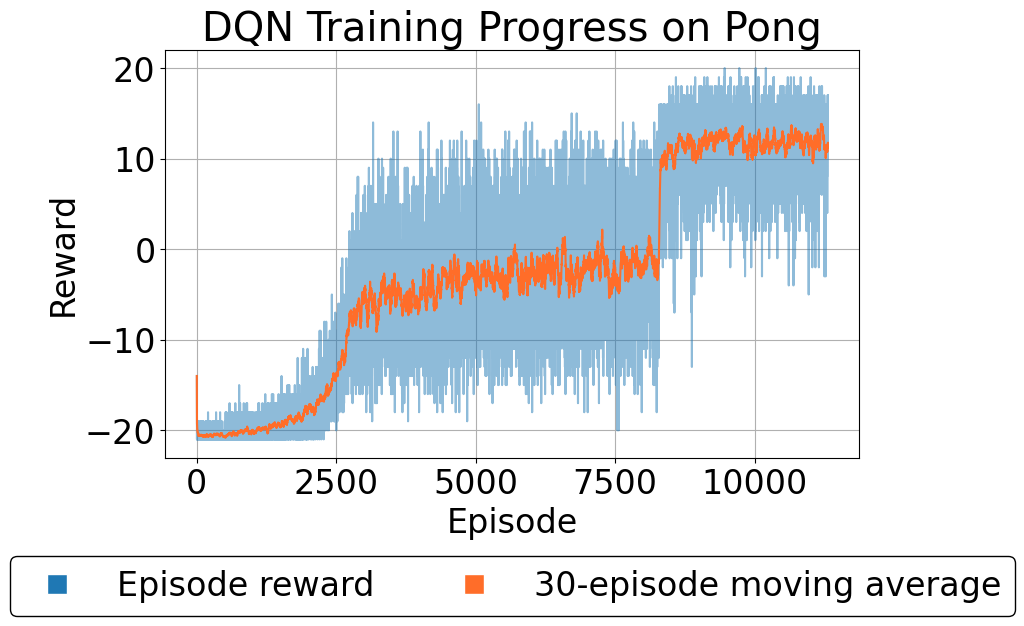

In [44]:
plot_rewards(episode_rewards, 30)

In [ ]:
import tqdm

# replay_buffer = ReplayBuffer(BUFFER_SIZE)
epsilon = EPS_START
print(frame_idx)
print(len(replay_buffer))
# frame_idx = 0
# episode_rewards = []

state, info = env.reset()
done = False
episode_reward = 0

best_avg_reward = 14
best_episode_reward = 20

# Fill replay buffer with random actions
if len(replay_buffer) < MIN_REPLAY_SIZE:
  print("Warming up replay buffer...")
  while len(replay_buffer) < MIN_REPLAY_SIZE:
      action = env.action_space.sample()
      next_state, reward, done, info = env.step(action)
      reward = np.clip(reward, -1, 1)
      replay_buffer.add(state, action, reward, next_state, done)
      state = next_state if not done else env.reset()[0]

print("Replay buffer ready!")

# Main training loop
print("Starting training...")
pbar = tqdm.trange(frame_idx, TOTAL_FRAMES)
for frame_idx in pbar:
    epsilon = max(EPS_END, EPS_START - frame_idx / EPS_DECAY)
    action = select_action(policy_net, state, epsilon, NUM_ACTIONS)
    next_state, reward, done, info = env.step(action)
    reward = np.clip(reward, -1, 1) 

    replay_buffer.add(state, action, reward, next_state, done)
    state = next_state
    episode_reward += reward

    if done:
        state, info = env.reset()
        episode_rewards.append(episode_reward)
        if episode_reward > best_episode_reward:
          best_episode_reward = episode_reward
          save_best_model(
              frame_idx,
              policy_net,
              target_net,
              optimizer,
              episode_rewards,
              filename_prefix=CHECKPOINT_PATH + "/best_episode_model"
          )
          print(f"Best EPISODE model saved! New best avg reward: {best_episode_reward:.2f}")
        episode_reward = 0
        if len(episode_rewards) % 50 == 0 and len(episode_rewards) > 0:
          plot_rewards(episode_rewards)

    # Train the network
    if len(replay_buffer) >= MIN_REPLAY_SIZE:
        batch = replay_buffer.sample(BATCH_SIZE)
        loss = compute_td_loss(batch, policy_net, target_net)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Update target network
    if frame_idx % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Logging
    if frame_idx % 10_000 == 0 and frame_idx > 0:
        print(len(replay_buffer))
        avg_reward = np.mean(episode_rewards[-10:]) if episode_rewards else 0
        print(f"[{frame_idx} frames] Avg reward (last 10 episodes): {avg_reward:.2f}")
        if avg_reward > best_avg_reward:
          best_avg_reward = avg_reward
          save_best_model(
              frame_idx,
              policy_net,
              target_net,
              optimizer,
              episode_rewards,
              filename_prefix=CHECKPOINT_PATH + "/best_dqn_model"
          )
          print(f"Best model saved! New best avg reward: {best_avg_reward:.2f}")
    if frame_idx % 100_000 == 0 and frame_idx > 0:
      print(len(replay_buffer))
      save_best_model(
              frame_idx,
              policy_net,
              target_net,
              optimizer,
              episode_rewards,
              filename_prefix=CHECKPOINT_PATH + "/dqn_model_" + str(frame_idx)
          )
      save_full_checkpoint(frame_idx, policy_net, target_net, optimizer, replay_buffer, episode_rewards, CHECKPOINT_PATH + "dqn_full_checkpoint")

In [ ]:
save_full_checkpoint(frame_idx, policy_net, target_net, optimizer, replay_buffer, episode_rewards, CHECKPOINT_PATH + "dqn_full_checkpoint")

In [31]:
from gymnasium.wrappers import RecordVideo

eval_env = FrameStack(
    FrameSkip(
        RecordVideo(
            gym.make("ALE/Pong-v5", render_mode="rgb_array"),
            video_folder="./videos",
            episode_trigger=lambda e: True
        ),
        skip=4
    ),
    k=4
)

state, info = eval_env.reset()
done = False
total_reward = 0

while not done:
    action = select_action(policy_net, state, epsilon=0.0, num_actions=NUM_ACTIONS)
    state, reward, done, info = eval_env.step(action)
    total_reward += reward

eval_env.close()
print(f"Test episode reward: {total_reward}")

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /kaggle/working/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequenc

Moviepy - Building video /kaggle/working/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /kaggle/working/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/videos/rl-video-episode-0.mp4
Test episode reward: 10.0


In [ ]:
eval_env = FrameStack(
    RecordVideo(
        FrameSkip(
            gym.make("ALE/Pong-v5", render_mode="rgb_array"),
            skip=4
        ),
        video_folder="./videos",
        episode_trigger=lambda e: True
    ),
    k=4
)

state, info = eval_env.reset()
done = False
total_reward = 0

while not done:
    action = select_action(policy_net, state, epsilon=0.0, num_actions=NUM_ACTIONS)
    state, reward, done, info = eval_env.step(action)
    total_reward += reward

eval_env.close()
print(f"Test episode reward: {total_reward}")

In [ ]:
NUM_TESTS = 200
VIDEO_DIR = "./videos"
test_rewards = []

for test_idx in range(NUM_TESTS):
    env = FrameStack(
        RecordVideo(
            FrameSkip(
                gym.make("ALE/Pong-v5", render_mode="rgb_array"),
                skip=4
            ),
            video_folder=VIDEO_DIR,
            episode_trigger=lambda e: e == 0 and test_idx == 0  # grabar solo el primer test
        ),
        k=4
    )

    state, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = select_action(policy_net, state, epsilon=0.0, num_actions=NUM_ACTIONS)
        state, reward, done, info = env.step(action)
        total_reward += reward

    test_rewards.append(total_reward)
    env.close()

# Mostrar resultados
plt.figure(figsize=(10, 5))
plt.plot(test_rewards, marker='o')
plt.title("Resultados de las pruebas")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.grid(True)
plt.show()

print("Recompensas de prueba:", test_rewards)
print("Media:", np.mean(test_rewards), "Desviación estándar:", np.std(test_rewards))

In [32]:
load_best_model(CHECKPOINT_PATH + "/best_dqn_model", policy_net, target_net, optimizer)

Loaded best model from frame 7900000


(7900000,
 [-14.0,
  -21.0,
  -21.0,
  -21.0,
  -20.0,
  -21.0,
  -20.0,
  -21.0,
  -21.0,
  -20.0,
  -20.0,
  -20.0,
  -21.0,
  -21.0,
  -21.0,
  -20.0,
  -21.0,
  -21.0,
  -21.0,
  -19.0,
  -21.0,
  -21.0,
  -21.0,
  -19.0,
  -21.0,
  -21.0,
  -21.0,
  -20.0,
  -21.0,
  -20.0,
  -21.0,
  -21.0,
  -20.0,
  -20.0,
  -21.0,
  -21.0,
  -21.0,
  -21.0,
  -20.0,
  -20.0,
  -20.0,
  -21.0,
  -20.0,
  -21.0,
  -21.0,
  -20.0,
  -21.0,
  -21.0,
  -19.0,
  -21.0,
  -21.0,
  -21.0,
  -21.0,
  -21.0,
  -20.0,
  -20.0,
  -21.0,
  -20.0,
  -21.0,
  -21.0,
  -20.0,
  -20.0,
  -20.0,
  -19.0,
  -21.0,
  -21.0,
  -21.0,
  -21.0,
  -21.0,
  -21.0,
  -20.0,
  -21.0,
  -21.0,
  -21.0,
  -21.0,
  -19.0,
  -20.0,
  -21.0,
  -21.0,
  -20.0,
  -21.0,
  -21.0,
  -19.0,
  -21.0,
  -20.0,
  -21.0,
  -20.0,
  -21.0,
  -20.0,
  -21.0,
  -21.0,
  -21.0,
  -21.0,
  -20.0,
  -21.0,
  -21.0,
  -21.0,
  -21.0,
  -20.0,
  -21.0,
  -21.0,
  -21.0,
  -21.0,
  -20.0,
  -21.0,
  -20.0,
  -21.0,
  -20.0,
  -19.0,
  -21.0,


In [33]:
NUM_TESTS = 200
VIDEO_DIR = "./videos"
test_rewards = []

for test_idx in range(NUM_TESTS):
    env = FrameStack(
        RecordVideo(
            FrameSkip(
                gym.make("ALE/Pong-v5", render_mode="rgb_array"),
                skip=4
            ),
            video_folder=VIDEO_DIR,
            episode_trigger=lambda e: e == 0 and test_idx == 0  # grabar solo el primer test
        ),
        k=4
    )

    state, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = select_action(policy_net, state, epsilon=0.0, num_actions=NUM_ACTIONS)
        state, reward, done, info = env.step(action)
        total_reward += reward

    test_rewards.append(total_reward)
    env.close()

# Mostrar resultados
plt.figure(figsize=(10, 5))
plt.plot(test_rewards, marker='o')
plt.title("Resultados de las pruebas")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.grid(True)
plt.show()

print("Recompensas de prueba:", test_rewards)
print("Media:", np.mean(test_rewards), "Desviación estándar:", np.std(test_rewards))

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /kaggle/working/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video /kaggle/working/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /kaggle/working/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/videos/rl-video-episode-0.mp4


KeyboardInterrupt: 

Moviepy - Building video /kaggle/working/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /kaggle/working/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/videos/rl-video-episode-0.mp4


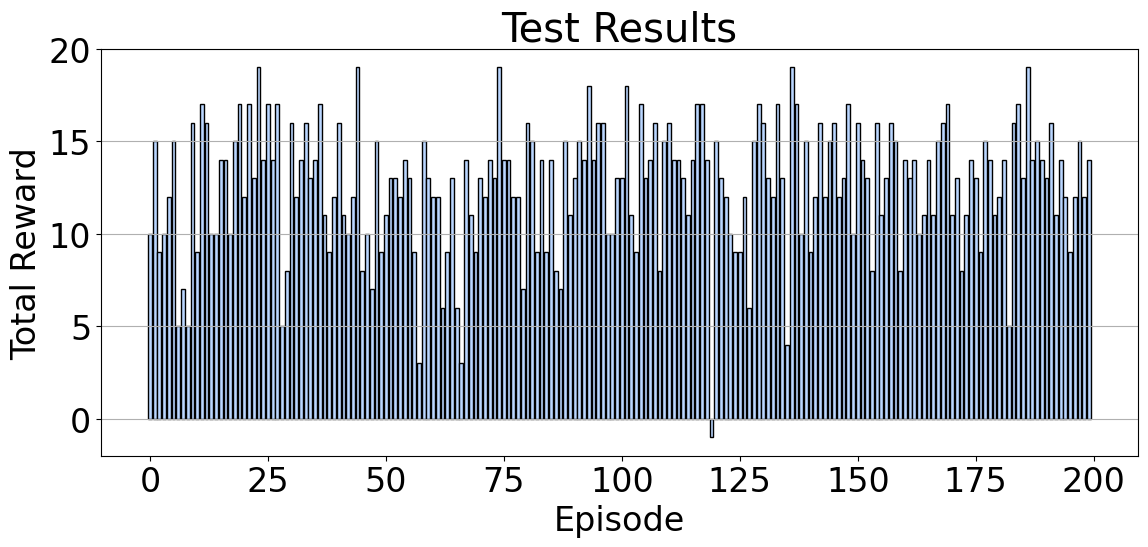

Test rewards: [10.0, 15.0, 9.0, 10.0, 12.0, 15.0, 5.0, 7.0, 5.0, 16.0, 9.0, 17.0, 16.0, 10.0, 10.0, 14.0, 14.0, 10.0, 15.0, 17.0, 12.0, 17.0, 13.0, 19.0, 14.0, 17.0, 14.0, 17.0, 5.0, 8.0, 16.0, 12.0, 14.0, 16.0, 13.0, 14.0, 17.0, 11.0, 9.0, 12.0, 16.0, 11.0, 10.0, 12.0, 19.0, 8.0, 10.0, 7.0, 15.0, 9.0, 11.0, 13.0, 13.0, 12.0, 14.0, 13.0, 9.0, 3.0, 15.0, 13.0, 12.0, 12.0, 6.0, 9.0, 13.0, 6.0, 3.0, 14.0, 11.0, 9.0, 13.0, 12.0, 14.0, 13.0, 19.0, 14.0, 14.0, 12.0, 12.0, 7.0, 16.0, 15.0, 9.0, 14.0, 9.0, 14.0, 8.0, 7.0, 15.0, 11.0, 13.0, 15.0, 14.0, 18.0, 14.0, 16.0, 16.0, 10.0, 10.0, 13.0, 13.0, 18.0, 11.0, 9.0, 17.0, 13.0, 14.0, 16.0, 8.0, 15.0, 16.0, 14.0, 14.0, 13.0, 11.0, 14.0, 17.0, 17.0, 14.0, -1.0, 15.0, 13.0, 12.0, 10.0, 9.0, 9.0, 12.0, 6.0, 15.0, 17.0, 16.0, 13.0, 12.0, 17.0, 13.0, 4.0, 19.0, 17.0, 10.0, 15.0, 9.0, 12.0, 16.0, 12.0, 15.0, 16.0, 12.0, 13.0, 17.0, 10.0, 16.0, 14.0, 13.0, 8.0, 16.0, 11.0, 13.0, 16.0, 15.0, 8.0, 14.0, 13.0, 14.0, 10.0, 11.0, 14.0, 11.0, 15.0, 16.0, 17.

In [36]:
NUM_TESTS = 200
VIDEO_DIR = "./videos"
test_rewards = []

for test_idx in range(NUM_TESTS):
    env = FrameStack(
        RecordVideo(
            FrameSkip(
                gym.make("ALE/Pong-v5", render_mode="rgb_array"),
                skip=4
            ),
            video_folder=VIDEO_DIR,
            episode_trigger=lambda e: e == 0 and test_idx == 0  # record only first test
        ),
        k=4
    )

    state, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = select_action(policy_net, state, epsilon=0.0, num_actions=NUM_ACTIONS)
        state, reward, done, info = env.step(action)
        total_reward += reward

    test_rewards.append(total_reward)
    env.close()

# Plot results with improved style
plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 24})

plt.bar(range(NUM_TESTS), test_rewards, color="#BAD6FF", edgecolor='black')
plt.title("Test Results")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Print summary in English
print("Test rewards:", test_rewards)
print("Average reward:", np.mean(test_rewards))

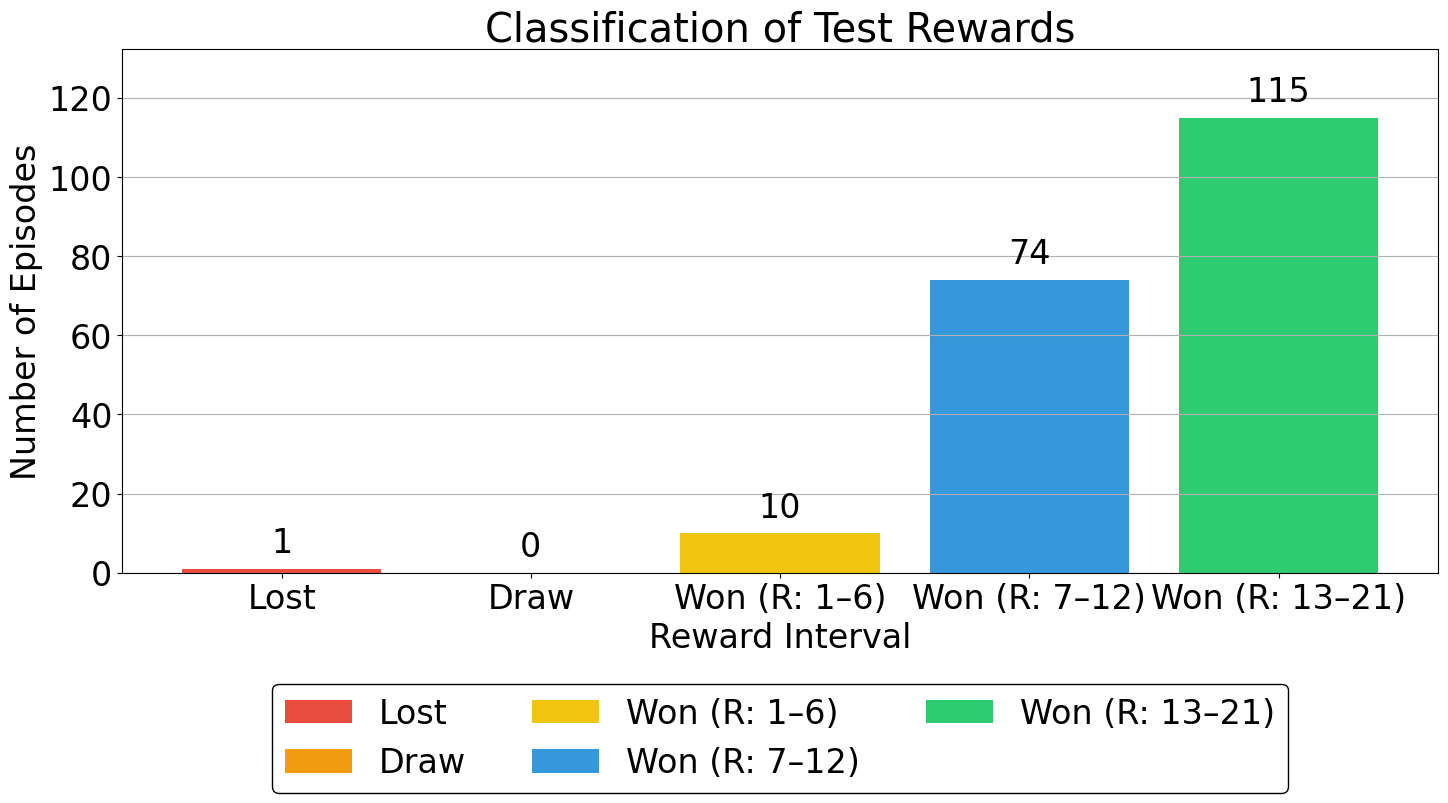

In [76]:
# Define reward category ranges and labels
category_counts = {
    "Lost": sum(r < 0 for r in test_rewards),
    "Draw": sum(r == 0 for r in test_rewards),
    "Won (R: 1–6)": sum(1 <= r <= 6 for r in test_rewards),
    "Won (R: 7–12)": sum(7 <= r <= 12 for r in test_rewards),
    "Won (R: 13–21)": sum(13 <= r <= 21 for r in test_rewards)
}

# Define ordered categories and original color palette
categories = ["Lost", "Draw", "Won (R: 1–6)", "Won (R: 7–12)", "Won (R: 13–21)"]
colors = {
    "Lost": "#E74C3C",          # red
    "Draw": "#F39C12",          # orange
    "Won (R: 1–6)": "#F1C40F",  # yellow
    "Won (R: 7–12)": "#3498DB", # blue
    "Won (R: 13–21)": "#2ECC71" # green
}

# Plot setup
plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 24})

counts = [category_counts[c] for c in categories]
bars = plt.bar(
    categories,
    counts,
    color=[colors[c] for c in categories]
)

# Set Y-axis limit to avoid label clipping
max_height = max(counts)
plt.ylim(0, max_height * 1.15)

# Add count labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max_height * 0.02,
        str(int(height)),
        ha='center',
        va='bottom',
        color='black'
    )

plt.xlabel("Reward Interval")
plt.ylabel("Number of Episodes")
plt.title("Classification of Test Rewards")
plt.grid(axis='y')

# Legend below with border
legend_elements = [Patch(facecolor=colors[c], label=c) for c in categories]
plt.legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=3,
    frameon=True,
    edgecolor='black',
    framealpha=1.0,
    fancybox=True
)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

TypeError: list indices must be integers or slices, not str

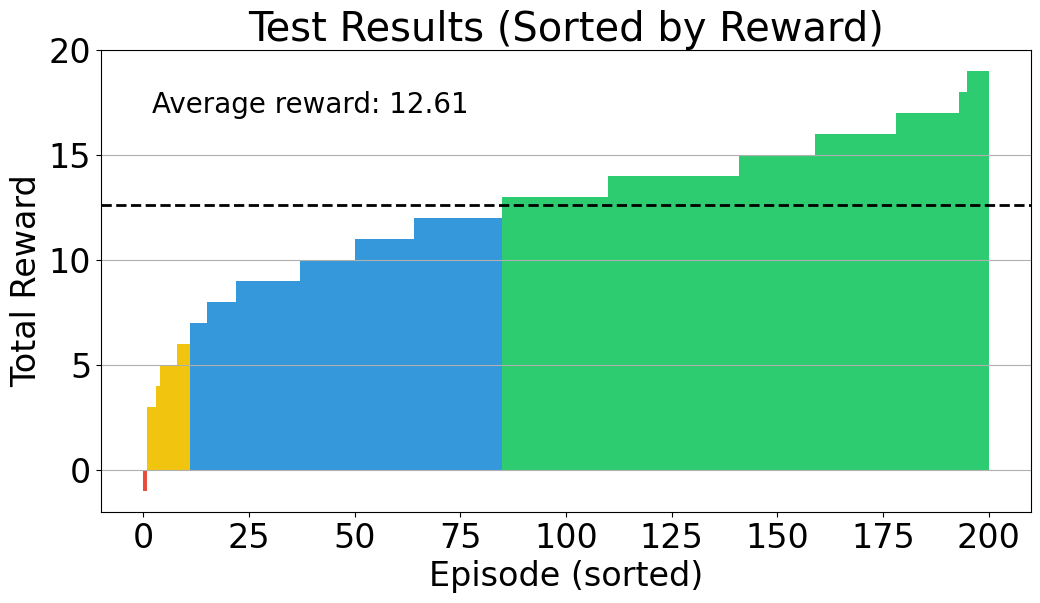

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Define reward category ranges and labels
category_counts = {
    "Lost": sum(r < 0 for r in test_rewards),
    "Draw": sum(r == 0 for r in test_rewards),
    "Won (R: 1–6)": sum(1 <= r <= 6 for r in test_rewards),
    "Won (R: 7–12)": sum(7 <= r <= 12 for r in test_rewards),
    "Won (R: 13–21)": sum(13 <= r <= 21 for r in test_rewards)
}

# Define ordered categories and original color palette
categories = ["Lost", "Draw", "Won (R: 1–6)", "Won (R: 7–12)", "Won (R: 13–21)"]
colors = {
    "Lost": "#E74C3C",          # red
    "Draw": "#F39C12",          # orange
    "Won (R: 1–6)": "#F1C40F",  # yellow
    "Won (R: 7–12)": "#3498DB", # blue
    "Won (R: 13–21)": "#2ECC71" # green
}


# Replace with your actual test_rewards
# test_rewards = [...]

# Sort rewards
sorted_rewards = sorted(test_rewards)

# Assign colors by reward
colors = []
for r in sorted_rewards:
    if r < 0:
        colors.append("#E74C3C")      # red
    elif r == 0:
        colors.append("#F39C12")      # orange
    elif 1 <= r <= 6:
        colors.append("#F1C40F")      # yellow
    elif 7 <= r <= 12:
        colors.append("#3498DB")      # blue
    elif 13 <= r <= 21:
        colors.append("#2ECC71")      # green
    else:
        colors.append("gray")

# Average
avg_reward = np.mean(test_rewards)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update({'font.size': 24})

# Use width=1 and align='edge' to eliminate gaps
ax.bar(
    x=range(len(sorted_rewards)),
    height=sorted_rewards,
    color=colors,
    width=1.0,
    align='edge'
)

# Add average reward line
ax.axhline(y=avg_reward, color='black', linestyle='--', linewidth=2)

# Titles and labels
ax.set_title("Test Results (Sorted by Reward)")
ax.set_xlabel("Episode (sorted)")
ax.set_ylabel("Total Reward")
ax.grid(axis='y')

# Text inside top-left
ax.text(
    2, max(sorted_rewards) * 0.95,
    f"Average reward: {avg_reward:.2f}",
    ha='left', va='top',
    fontsize=20
)

# Legend below with border
legend_elements = [Patch(facecolor=colors[c], label=c) for c in categories]
plt.legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=3,
    frameon=True,
    edgecolor='black',
    framealpha=1.0,
    fancybox=True
)

plt.tight_layout()
plt.show()

# Console output
print("Average reward:", avg_reward)


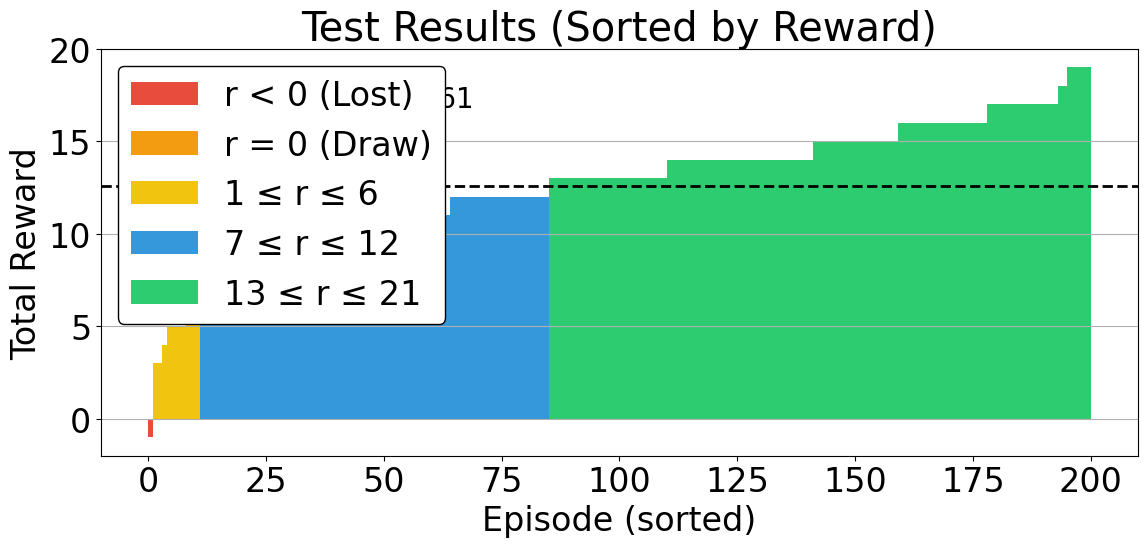

Average reward: 12.605


In [77]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Replace with your actual test_rewards
# test_rewards = [...]

# Sort rewards
sorted_rewards = sorted(test_rewards)

# Assign colors by reward
colors = []
for r in sorted_rewards:
    if r < 0:
        colors.append("#E74C3C")      # red
    elif r == 0:
        colors.append("#F39C12")      # orange
    elif 1 <= r <= 6:
        colors.append("#F1C40F")      # yellow
    elif 7 <= r <= 12:
        colors.append("#3498DB")      # blue
    elif 13 <= r <= 21:
        colors.append("#2ECC71")      # green
    else:
        colors.append("gray")

# Average
avg_reward = np.mean(test_rewards)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update({'font.size': 24})

# Use width=1 and align='edge' to eliminate gaps
ax.bar(
    x=range(len(sorted_rewards)),
    height=sorted_rewards,
    color=colors,
    width=1.0,
    align='edge'
)

# Add average reward line
ax.axhline(y=avg_reward, color='black', linestyle='--', linewidth=2)

# Titles and labels
ax.set_title("Test Results (Sorted by Reward)")
ax.set_xlabel("Episode (sorted)")
ax.set_ylabel("Total Reward")
ax.grid(axis='y')

# Text inside top-left
ax.text(
    2, max(sorted_rewards) * 0.95,
    f"Average reward: {avg_reward:.2f}",
    ha='left', va='top',
    fontsize=20
)

# Legend handles
legend_elements = [
    Patch(facecolor="#E74C3C", label="r < 0 (Lost)"),
    Patch(facecolor="#F39C12", label="r = 0 (Draw)"),
    Patch(facecolor="#F1C40F", label="1 ≤ r ≤ 6"),
    Patch(facecolor="#3498DB", label="7 ≤ r ≤ 12"),
    Patch(facecolor="#2ECC71", label="13 ≤ r ≤ 21")
]

# Add legend with border
ax.legend(
    handles=legend_elements,
    loc='upper left',
    frameon=True,
    edgecolor='black',
    framealpha=1.0,
    fancybox=True
)

plt.tight_layout()
plt.show()

# Console output
print("Average reward:", avg_reward)


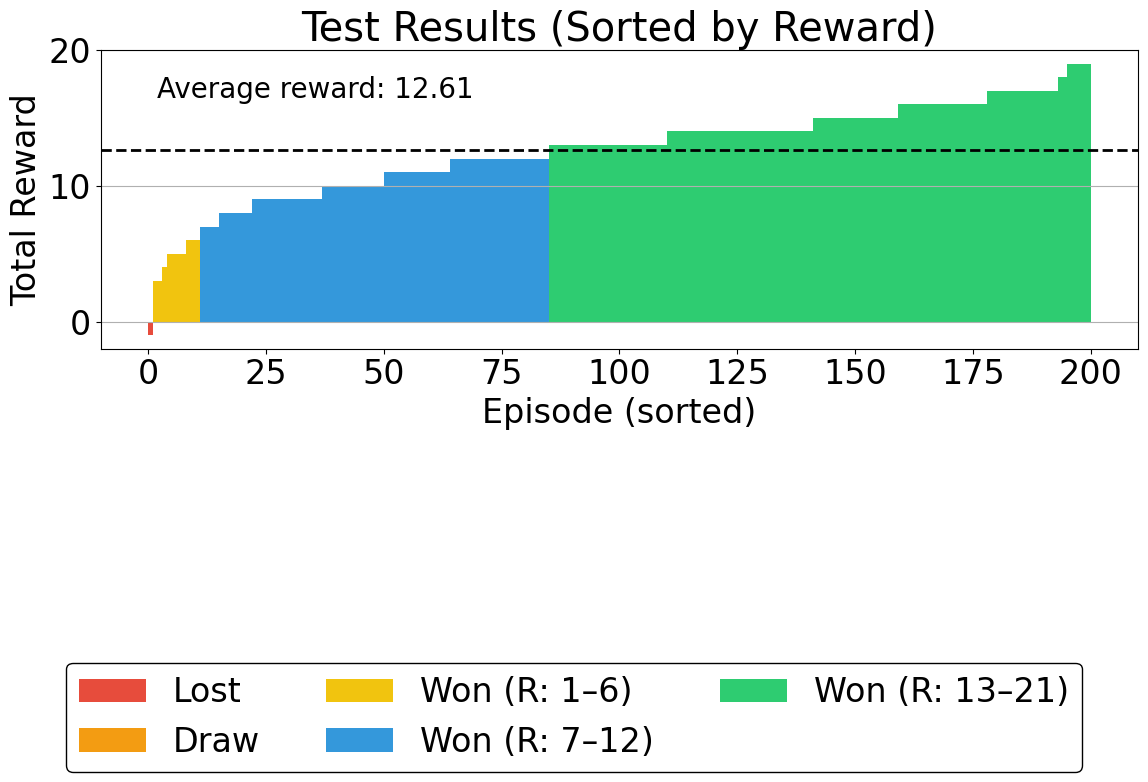

Average reward: 12.605


In [80]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Replace with your actual test_rewards
# test_rewards = [...]

# Sort rewards
sorted_rewards = sorted(test_rewards)

# Define reward category ranges and labels
category_counts = {
    "Lost": sum(r < 0 for r in test_rewards),
    "Draw": sum(r == 0 for r in test_rewards),
    "Won (R: 1–6)": sum(1 <= r <= 6 for r in test_rewards),
    "Won (R: 7–12)": sum(7 <= r <= 12 for r in test_rewards),
    "Won (R: 13–21)": sum(13 <= r <= 21 for r in test_rewards)
}

# Define ordered categories and original color palette
categories = ["Lost", "Draw", "Won (R: 1–6)", "Won (R: 7–12)", "Won (R: 13–21)"]
category_colors = {
    "Lost": "#E74C3C",          # red
    "Draw": "#F39C12",          # orange
    "Won (R: 1–6)": "#F1C40F",  # yellow
    "Won (R: 7–12)": "#3498DB", # blue
    "Won (R: 13–21)": "#2ECC71" # green
}

# Map colors for each sorted reward
colors = []
for r in sorted_rewards:
    if r < 0:
        colors.append(category_colors["Lost"])
    elif r == 0:
        colors.append(category_colors["Draw"])
    elif 1 <= r <= 6:
        colors.append(category_colors["Won (R: 1–6)"])
    elif 7 <= r <= 12:
        colors.append(category_colors["Won (R: 7–12)"])
    elif 13 <= r <= 21:
        colors.append(category_colors["Won (R: 13–21)"])
    else:
        colors.append("gray")

# Average
avg_reward = np.mean(test_rewards)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update({'font.size': 24})

# Bar chart without gaps
ax.bar(
    x=range(len(sorted_rewards)),
    height=sorted_rewards,
    color=colors,
    width=1.0,
    align='edge'
)

# Average reward line
ax.axhline(y=avg_reward, color='black', linestyle='--', linewidth=2)

# Titles and labels
ax.set_title("Test Results (Sorted by Reward)")
ax.set_xlabel("Episode (sorted)")
ax.set_ylabel("Total Reward")
ax.grid(axis='y')

# Average reward label inside top-left
ax.text(
    2, max(sorted_rewards) * 0.95,
    f"Average reward: {avg_reward:.2f}",
    ha='left', va='top',
    fontsize=20
)

# Legend setup
legend_elements = [Patch(facecolor=category_colors[c], label=c) for c in categories]

fig.legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.12),
    ncol=3,
    frameon=True,
    edgecolor='black',
    framealpha=1.0,
    fancybox=True
)

# Adjust layout to fit legend below
plt.tight_layout(rect=[0, 0.18, 1, 1])
plt.show()

# Output average
print("Average reward:", avg_reward)
